<a href="https://colab.research.google.com/github/leabizbille/ProjetIOT/blob/main/Marc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install summarytools -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.6 MB/s eta 0:00:00


In [2]:
!pip install pygwalker -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 956.2/956.2 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 48.5 MB/s eta 0:00:00


In [3]:
pip install sweetviz -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 76.6 MB/s eta 0:00:00


In [27]:
import pygwalker as pyg  # Crée des visualisations interactives basées sur pandas DataFrame, inspiré de Tableau.
from summarytools import dfSummary  # Génère des résumés descriptifs détaillés pour un DataFrame.
import pandas as pd  # Manipulation et analyse de données tabulaires, comme les CSV.
import matplotlib.pyplot as plt  # Création de graphiques statiques et personnalisables.
import seaborn as sns  # Extension de Matplotlib pour des graphiques plus élégants et statistiques.
import sweetviz as sv  # Génère des rapports HTML interactifs pour explorer les données.
import missingno as msno  # Visualisation des données manquantes (heatmaps, matrices, etc.).
from google.colab import files  # Permet de télécharger ou téléverser des fichiers depuis/vers Colab.

import numpy as np  # Manipulation de données numériques (tableaux, statistiques simples, etc.).
from scipy import stats  # Fonctions statistiques avancées (tests, distributions, etc.).
import statsmodels.api as sm  # Analyse statistique avancée et modélisation (régressions, ANOVA, etc.).
from statsmodels.formula.api import ols  # Régression linéaire avec formules (similaire à R).
import plotly.graph_objects as go  # Création de visualisations interactives avancées avec Plotly.
from datetime import datetime, time


In [6]:
from google.colab import files
uploaded = files.upload()  # Vous serez invité à sélectionner votre fichier


Saving Marc_SmartOme.csv to Marc_SmartOme.csv


In [9]:
# Charger le fichier CSV en conservant les titres des colonnes
Marc= pd.read_csv("/content/Marc_SmartOme.csv",sep= ";")


<Axes: >

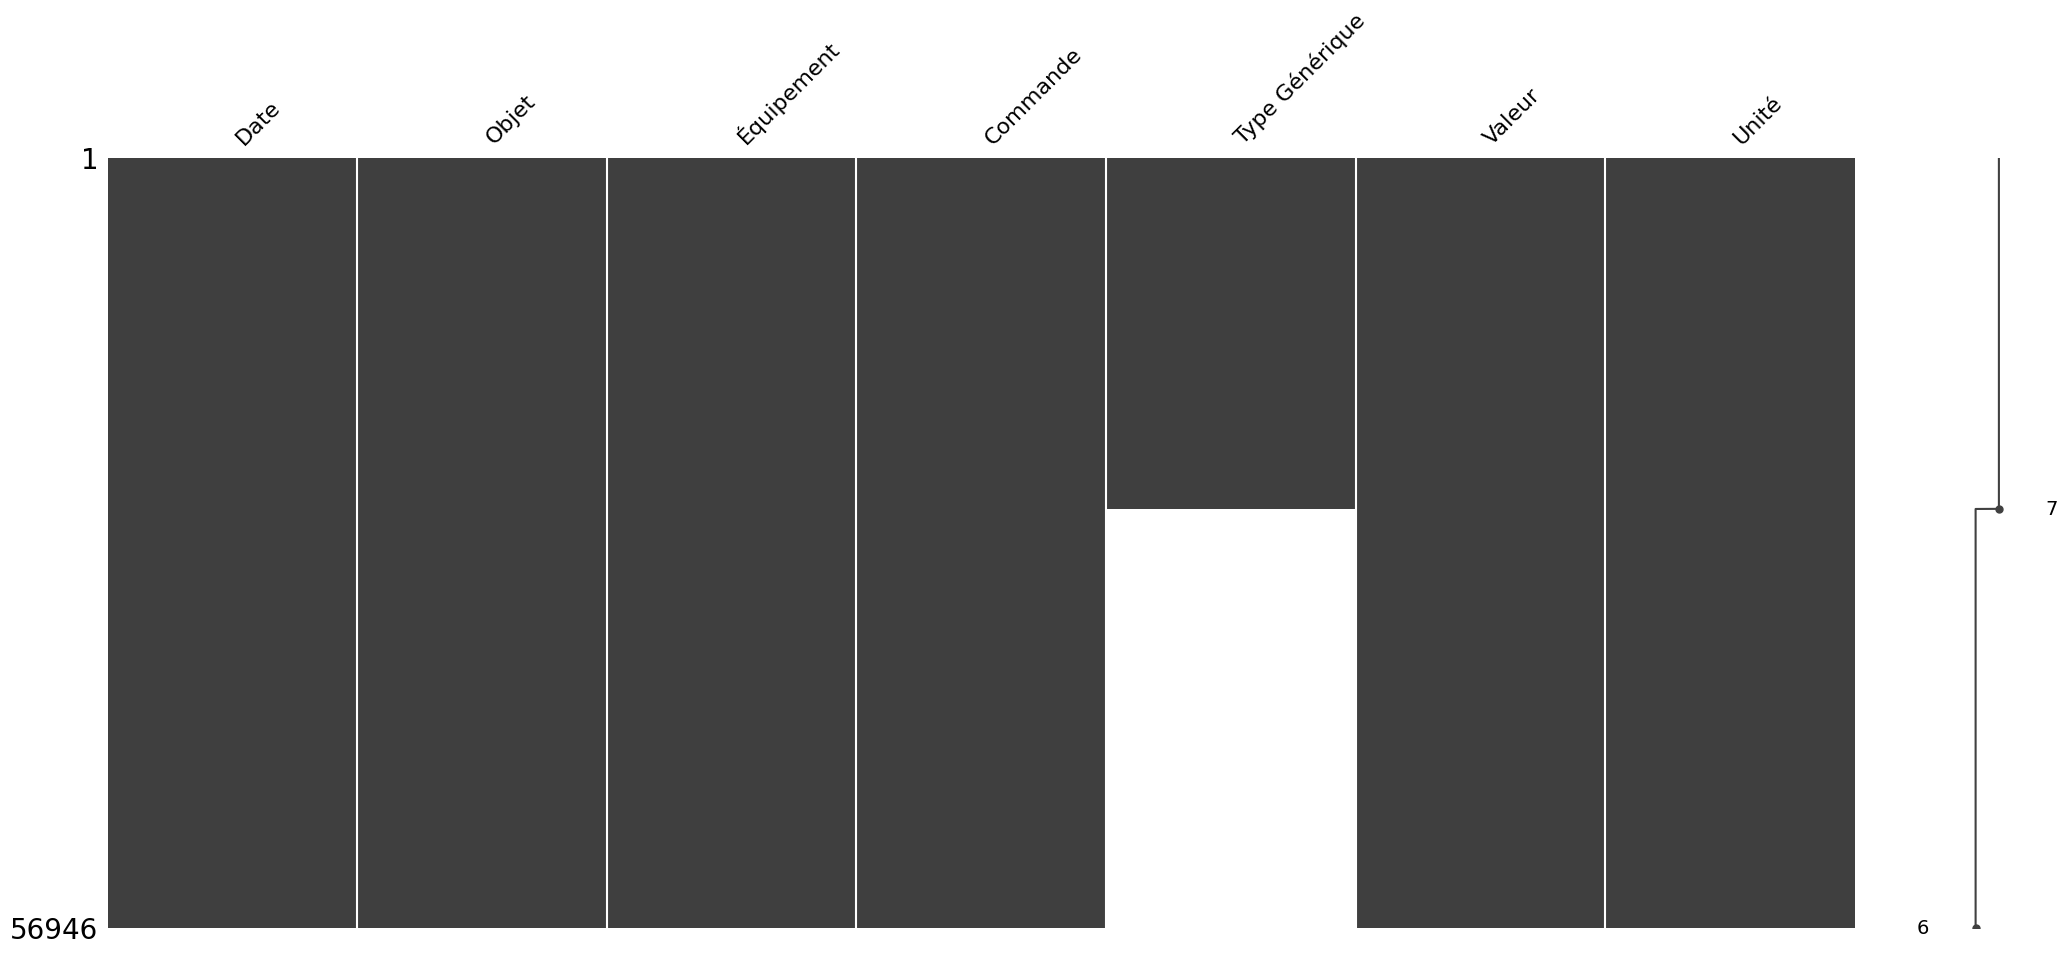

In [10]:
msno.matrix(Marc)

In [24]:
# Description pour comprendre les données et mettre en suite le tableau en forme
dfSummary(Marc)

/usr/local/lib/python3.10/dist-packages/summarytools/summarytools.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  stats += f"<br>IQR (CV) : {x.quantile(0.75) - x.quantile(0.25):.1f} ({x.mean()/x.std():.1f})"


No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Date[object],1. 2024-04-30 02:00:002. 2024-02-24 06:00:003. 2024-04-18 02:00:004. 2024-04-10 02:00:005. 2024-05-21 02:00:006. 2024-03-05 10:00:007. 2024-03-21 06:00:008. 2024-04-19 02:00:009. 2024-04-26 02:00:0010. 2024-05-17 02:00:0011. other,"11 (0.0%)10 (0.0%)10 (0.0%)10 (0.0%)10 (0.0%)10 (0.0%)10 (0.0%)10 (0.0%)10 (0.0%)10 (0.0%)56,845 (99.8%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Objet[object],1. TECHNIQUE2. OPENSPACE3. BUREAU 1 (MARC)4. CUISINE5. BUREAU 2 (ARCHIVES),"30,991 (54.4%)8,620 (15.1%)8,302 (14.6%)6,867 (12.1%)2,166 (3.8%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACM0lEQVR4nO3bQWrbUBiF0V/FhGYiYQxejBfRxXYR2o0x1qAJmaiDQghu7Eyerlz3nBU8zIeMxLvdPM8FCd/WPgD/D7ERIzZiuqp6rqqntQ/yQN7meX5Z+xD3aLPb7X70fb9d+yCPYpqmU9d1PwX3t03f99vD4fAyDMPr2of5153P5+/jOG6Px+NTVYntwqaqahiG1/1+/2vtwzyI57UPcK+8IBAjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMZuqP1dj1j7II/A73raZpuk0juO2XI1pYpqmU1W9rX2Oe+RaeHuuhV/R2Y2S4gWBmKX/Rv2l8G7RdZWlER8ttq6yNOLS0usqn1N45wWBGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IhZbF1lacSlRddVlkZ85Fo4MdZVxHhBIMbfKDHWVcRYVxFjXUWMFwRixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI8a6ihjrKmJcCyfGuoqY1k82TzKuajp4MXDhlmaDFwMXvtJ68GLgwlU+6hIjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjptm6ypqKrzRdV1lTcYsNAjHWVcTcerJ5StHU1XWVpRStfbquspRiCbfWVZZSNOWjLjFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZiPl1XWUqxhKvrKkspWrNBIMa6ihgvCMSIjZjfxzEON3LH9zwAAAAASUVORK5CYII="">",0(0.0%)
3,Équipement[object],1. TIC 1 (Suivi Conso Elec)2. Thermostat Open Space Z23. Thermostat Marc Z34. Thermostat Cuisine Z65. AIRZONE (Suivi Conso Elec)6. PAC (Suivi Conso Elec)7. Thermostat Archive Z58. APPOINT ELECTRIQUE (Suivi Cons,"18,514 (32.5%)8,620 (15.1%)8,302 (14.6%)6,867 (12.1%)6,807 (12.0%)5,302 (9.3%)2,166 (3.8%)368 (0.6%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAC4CAYAAAD0WZ4UAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADJklEQVR4nO3dXWoTUQCG4RMJojcJIdDFdBEu1kVkN6U0FyrexAt/EGkiTWbesfg8KzgXL6edYb52dTqdBhTeLH0A/h9iIyM2MmIjIzYyYiOzGmO8H2O8XfogE/h6Op0+L30Izlvv9/sPm81mt/RBbnU8Hh9Xq9VHwf271pvNZnd/f/95u91+Wfow13p6enp3OBx2Dw8Pb8cYYvtHrccYY7vdfrm7u/u09GFu9H7pA3CZBwQyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy6zG+f6Kz9EFu8drP/79YH4/Hx8PhsBuv/BOd4/H4OMb4uvQ5OM9n4WRW/vwClblvNrcNv8w6eDFC4XezDV6MUPjT3IOXV/2Ey7S81CUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMz2+DFCIU/zTp4MULhdz4LJ2PwQsYDAhk/RslYV5GxriJjXUXGAwIZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVkfBZOxrqKzNQ3m5uMsyYdvBi4cMlkgx

- Valeurs contiennent différents type.
- 54 % de donnée manquante dans "Type Générique". Chercher l'utilisation et analyse l'interet.

Pour toutes les colonnes, reformater les données.
Un pivotement ou une transposition du tableau sera probablement nécessaire.

Mélange des modalites entre pièces et type d équipement

In [12]:
# Séparer la colonne 'datetime' en deux colonnes distinctes
Marc[['date', 'time']] = Marc['Date'].str.split(' ', expand=True)

# Convertir les nouvelles colonnes au format datetime
Marc['date'] = pd.to_datetime(Marc['date'], format='%Y-%m-%d')
Marc['time'] = pd.to_datetime(Marc['time'], format='%H:%M:%S').dt.time


In [13]:
# Ajouter une colonne 'Mois' pour extraire le mois (1-12)
Marc['Mois'] = Marc['date'].dt.month

In [14]:
# Ajouter une colonne 'Semaine' pour extraire la semaine de l'année
Marc['Semaine'] = Marc['date'].dt.isocalendar().week

In [15]:
# Créer une colonne 'Année' si elle n'existe pas déjà
Marc['annee'] = Marc['date'].dt.year

In [30]:
# Vérifier et convertir si nécessaire
if isinstance(Marc['time'].iloc[0], time):  # Si déjà au format datetime.time
    time_column = Marc['time']
elif Marc['time'].dtype == 'object':  # Si la colonne est au format chaîne
    time_column = pd.to_datetime(Marc['time']).dt.time
else:
    raise ValueError("Le format de la colonne 'time' n'est pas compatible.")


In [31]:
# Ajouter une colonne 'Jour/Nuit' basée sur l'heure
Marc['Jour/Nuit'] = np.where(
    (Marc['Date'] >= '20:00:00') | (Marc['Date'] < '08:00:00'),
    'Nuit',
    'Jour'
)


In [32]:
# Ajouter une colonne 'Ete/Hiver' basée sur le mois (valeurs numériques)
Marc['Ete/Hiver'] = np.where(
    (Marc['Mois'] >= 5) & (Marc['Mois'] <= 9),  # Mois de mai (5) à septembre (9) inclus
    'Ete',  # Été
    'Hiver'  # Hiver
)

In [33]:
# Supprimer l'ancienne colonne si elle n'est plus nécessaire
Marc= Marc.drop(columns=['Type Générique'])

In [34]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = Marc['Objet'].unique()

# Afficher les modalités
print(modalites)

['BUREAU 1 (MARC)' 'BUREAU 2 (ARCHIVES)' 'CUISINE' 'OPENSPACE' 'TECHNIQUE']


In [35]:
# Fonction de nettoyage
def nettoyer_Objet(data):
    if data == 'BUREAU 1 (MARC)': # Changement de nom
        return 'Bureau'
    elif data == 'BUREAU 2 (ARCHIVES)': # Changement de nom
        return 'Bureau'
    elif data == 'CUISINE':  # Clarifie
        return 'Cuisine'
    elif data == 'OPENSPACE':  # Clarifie
        return 'Open_Space'
    elif data == 'TECHNIQUE': # Changement de nom
        return 'Technique'
    else:
        return data  # Conserve les autres modalités intactes
# Appliquer la fonction de nettoyage à la colonne 'Objets'
Marc['Piece'] = Marc['Objet'].apply(nettoyer_Objet)

In [36]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = Marc['Équipement'].unique()

# Afficher les modalités
print(modalites)

['Thermostat Marc Z3' 'Thermostat Archive Z5' 'Thermostat Cuisine Z6'
 'Thermostat Open Space Z2' 'AIRZONE (Suivi Conso Elec)'
 'APPOINT ELECTRIQUE (Suivi Conso)' 'PAC (Suivi Conso Elec)'
 'TIC 1 (Suivi Conso Elec)']


In [37]:
# Fonction de nettoyage
def nettoyer_type(data):
    if data == 'Thermostat Marc Z3': # Changement de nom
        return 'Thermostats'
    elif data == 'Thermostat Archive Z5': #
        return 'Thermostats'
    elif data == 'Thermostat Cuisine Z6':  #
        return 'Thermostats'
    elif data == 'Thermostat Open Space Z2':  #
        return 'Thermostats'
    elif data == 'AIRZONE (Suivi Conso Elec)': #
        return 'AirZone'
    elif data == 'APPOINT ELECTRIQUE (Suivi Conso)':  #
        return 'Appoint-Electrique'
    elif data == 'PAC (Suivi Conso Elec)':  #
        return 'Compteurs'
    elif data == 'TIC 1 (Suivi Conso Elec)':  #
        return 'Compteurs'
    else:
        return data  # Conserve les autres modalités intactes
# Appliquer la fonction de nettoyage à la colonne 'Objets'
Marc['Objet'] = Marc['Équipement'].apply(nettoyer_type)

In [38]:
# Fonction de nettoyage
def nettoyer(data):
    if data == 'Thermostat Marc Z3': # Changement de nom
        return 'Z3'
    elif data == 'Thermostat Archive Z5': # Changement de nom
        return 'Z5'
    elif data == 'Thermostat Cuisine Z6':  # Clarifie
        return 'Z6'
    elif data == 'Thermostat Open Space Z2':  # Clarifie
        return 'Z2'
    elif data == 'AIRZONE (Suivi Conso Elec)': # Changement de nom
        return 'AirZone'
    elif data == 'APPOINT ELECTRIQUE (Suivi Conso)':  # Clarifie
        return 'Appoint-Electrique'
    elif data == 'PAC (Suivi Conso Elec)':  # Clarifie
        return 'PAC'
    elif data == 'TIC 1 (Suivi Conso Elec)':  # Clarifie
        return 'TIC'
    else:
        return data  # Conserve les autres modalités intactes
# Appliquer la fonction de nettoyage à la colonne 'Objets'
Marc['Réplicat'] = Marc['Équipement'].apply(nettoyer)

In [39]:
# Fonction de nettoyage
def nettoyer_Equipement(data):
    if data.startswith('Thermostat'):
        return 'Thermostat'
    else :
        return 'Conso_Objet'
    return data

# Appliquer la fonction de nettoyage à la colonne 'Objets'
Marc['Équipement'] = Marc['Équipement'].apply(nettoyer_Equipement)

In [40]:
# Description pour comprendre les données et mettre en suite le tableau en forme
#dfSummary(Marc)

In [41]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = Marc['Commande'].unique()

# Afficher les modalités
print(modalites)

['Température ambiante' 'Consommation jour' 'Consommation mois']


In [42]:
def nettoyer_Commande(data):
    data = data.strip()  # Supprime les espaces au début et à la fin
    if data.startswith('Température ambiante'):
        return 'Température'
    elif data == 'Consommation jour':  # Nettoie "Conso "
        return 'Conso_jour'
    elif data == 'Consommation mois':
        return 'Conso_mois'
    else:
        return data  # Conserve les autres modalités intactes

# Appliquer la fonction de nettoyage à la colonne Equipement
Marc['Commande'] = Marc['Commande'].apply(nettoyer_Commande)

In [43]:
Marc['Valeur'] = pd.to_numeric(Marc['Valeur'].str.replace(',', '.'), errors='coerce')

In [44]:
print(Marc.isna().sum())

Date          0
Objet         0
Équipement    0
Commande      0
Valeur        0
Unité         0
date          0
time          0
Mois          0
Semaine       0
annee         0
Jour/Nuit     0
Ete/Hiver     0
Piece         0
Réplicat      0
dtype: int64


Rapport des données nettoyées :

In [45]:
#my_report = sv.analyze(Marc)

In [46]:
#my_report.show_html()

Rapport des données de Val Roland, binaire entre les appartements les T°C et les conso

In [47]:
#my_report = sv.compare_intra(Marc, Marc["Unité"] == "kWh", ["Consommation", "Température"])

In [48]:
#my_report.show_html()

In [50]:
# Sauvegarder le DataFrame en tant que fichier CSV
#Marc.to_csv('Marc_export.csv', index=False)

# Télécharger le fichier dans votre machine locale
#files.download('Marc_export.csv')

Graphiques, pour analyse visuelle.

In [65]:
# Filtrer les données pour "Unité" en °C
data_celsius = Marc[Marc['Unité'] == '°C']  # Vérifier que 'Unité' est bien une chaîne

In [63]:

# Créer la figure avec toutes les traces initiales
fig = go.Figure()

# Ajouter une trace pour chaque réplicat
replicats = data_celsius['Réplicat'].unique()
for i, replicat in enumerate(replicats):
    data = data_celsius[data_celsius['Réplicat'] == replicat]
    fig.add_trace(go.Scatter(
        x=data['date'],
        y=data['Valeur'],
        mode='lines',
        name=f'Sonde {replicat}',
        visible=True  # Toutes les traces sont visibles par défaut
    ))

# Créer les boutons pour sélectionner une sonde spécifique ou toutes les sondes
buttons = [
    {
        'method': 'update',
        'label': f'Afficher {replicat}',
        'args': [
            {'visible': [i == j for j in range(len(fig.data))]},
            {'title': f'Évolution des températures pour la sonde {replicat}'}
        ]
    }
    for i, replicat in enumerate(replicats)
]

# Ajouter un bouton pour afficher toutes les sondes
buttons.append(
    {
        'method': 'update',
        'label': 'Afficher tout',
        'args': [
            {'visible': [True] * len(fig.data)},
            {'title': 'Évolution des températures par pièce'}
        ]
    }
)

# Ajouter le menu déroulant
fig.update_layout(
    updatemenus=[
        {
            'buttons': buttons,
            'direction': 'down',
            'showactive': True,
            'x': 0.17,
            'y': 1.15,
            'xanchor': 'left',
            'yanchor': 'top'
        }
    ],
    title='Évolution des températures par pièce',
    xaxis_title='Date',
    yaxis_title='Température (°C)',
    xaxis_tickangle=-45  # Rotation des dates pour lisibilité
)

# Afficher le graphique
fig.show()



Probleme avec la sonde 5 !

In [68]:
fig.write_html('graphique_interactif.html')


In [66]:
# Filtrer les données pour "Unité" en °C
data_Conso = Marc[Marc['Unité'] == 'kWh']  # Vérifier que 'Unité' est bien une chaîne

In [67]:
# Créer le graphique avec Plotly
fig = px.line(
    data_Conso,
    x='date',
    y='Valeur',
    color='Réplicat',  # Différencier les courbes par réplicat
    title="Évolution des consommation kWh par objet",
    labels={'date': 'Date', 'Valeur': 'Température (°C)'}
)

# Personnaliser les axes et le titre
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Consommation éléctrique (kWh)",
    xaxis_tickangle=-45  # Rotation des dates pour lisibilité
)

# Afficher le graphique
fig.show()



In [69]:
fig.write_html('graphique_interactif_consoBrut.html')

In [ ]:

# Créer la figure avec toutes les traces initiales
fig = go.Figure()

# Ajouter une trace pour chaque réplicat
replicats = data_celsius['Réplicat'].unique()
for i, replicat in enumerate(replicats):
    data = data_celsius[data_celsius['Réplicat'] == replicat]
    fig.add_trace(go.Scatter(
        x=data['date'],
        y=data['Valeur'],
        mode='lines',
        name=f'Sonde {replicat}',
        visible=True  # Toutes les traces sont visibles par défaut
    ))

# Créer les boutons pour sélectionner une sonde spécifique ou toutes les sondes
buttons = [
    {
        'method': 'update',
        'label': f'Afficher {replicat}',
        'args': [
            {'visible': [i == j for j in range(len(fig.data))]},
            {'title': f'Évolution des températures pour la sonde {replicat}'}
        ]
    }
    for i, replicat in enumerate(replicats)
]

# Ajouter un bouton pour afficher toutes les sondes
buttons.append(
    {
        'method': 'update',
        'label': 'Afficher tout',
        'args': [
            {'visible': [True] * len(fig.data)},
            {'title': 'Évolution des températures par pièce'}
        ]
    }
)

# Ajouter le menu déroulant
fig.update_layout(
    updatemenus=[
        {
            'buttons': buttons,
            'direction': 'down',
            'showactive': True,
            'x': 0.17,
            'y': 1.15,
            'xanchor': 'left',
            'yanchor': 'top'
        }
    ],
    title='Évolution des températures par pièce',
    xaxis_title='Date',
    yaxis_title='Température (°C)',
    xaxis_tickangle=-45  # Rotation des dates pour lisibilité
)

# Afficher le graphique
fig.show()

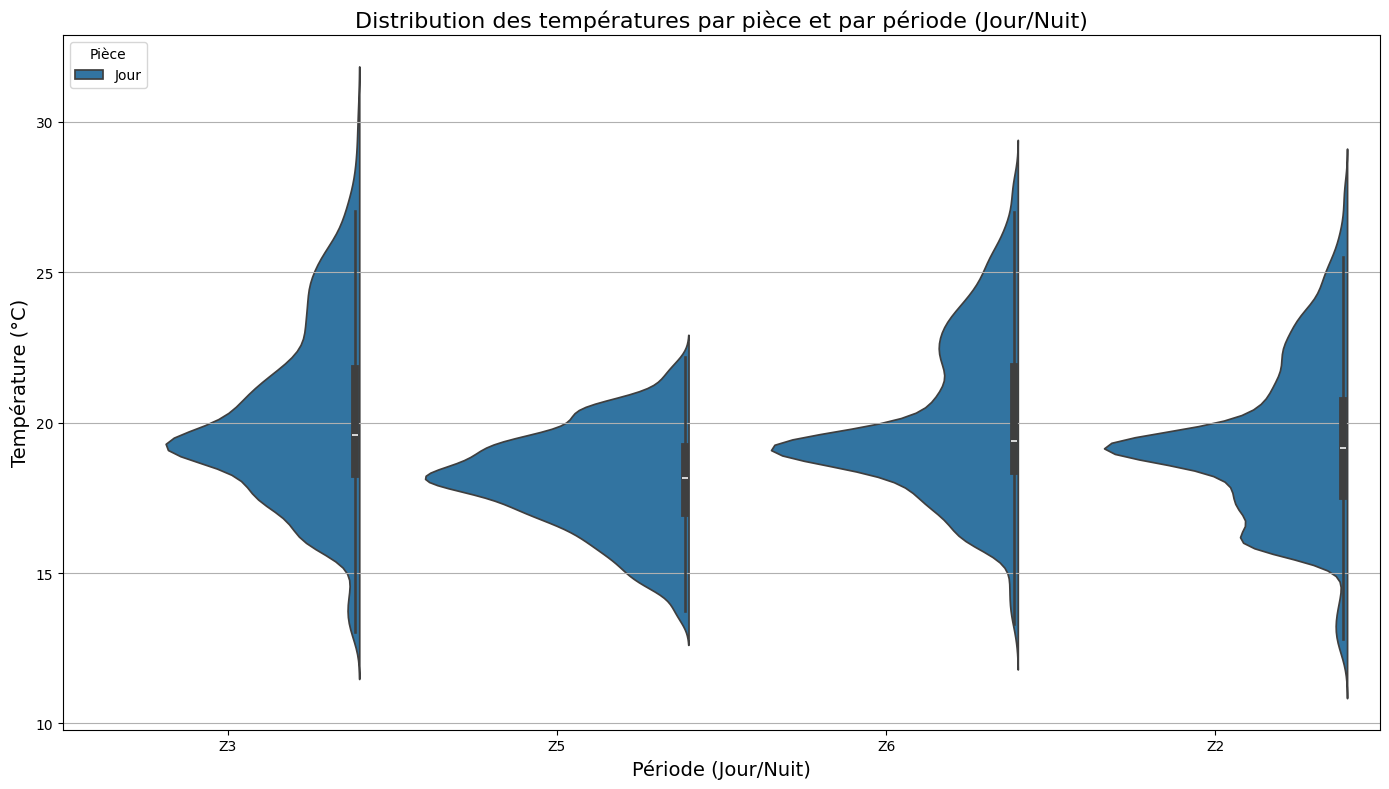

In [54]:

# Initialiser le graphique
plt.figure(figsize=(14, 8))

# Tracer un graphique en violon
sns.violinplot(
    data=data_celsius,
    x='Réplicat',  # Axe catégoriel
    y='Valeur',     # Température
    hue='Jour/Nuit',  # Différencier par réplicat
    split=True,     # Diviser les violons pour chaque réplicat
    palette='tab10'
)

# Ajouter des labels et une légende
plt.title("Distribution des températures par pièce et par période (Jour/Nuit)", fontsize=16)
plt.xlabel("Période (Jour/Nuit)", fontsize=14)
plt.ylabel("Température (°C)", fontsize=14)
plt.legend(title="Pièce", loc='upper left', fontsize=10)
plt.grid(True, axis='y')

# Afficher le graphique
plt.tight_layout()
plt.show()


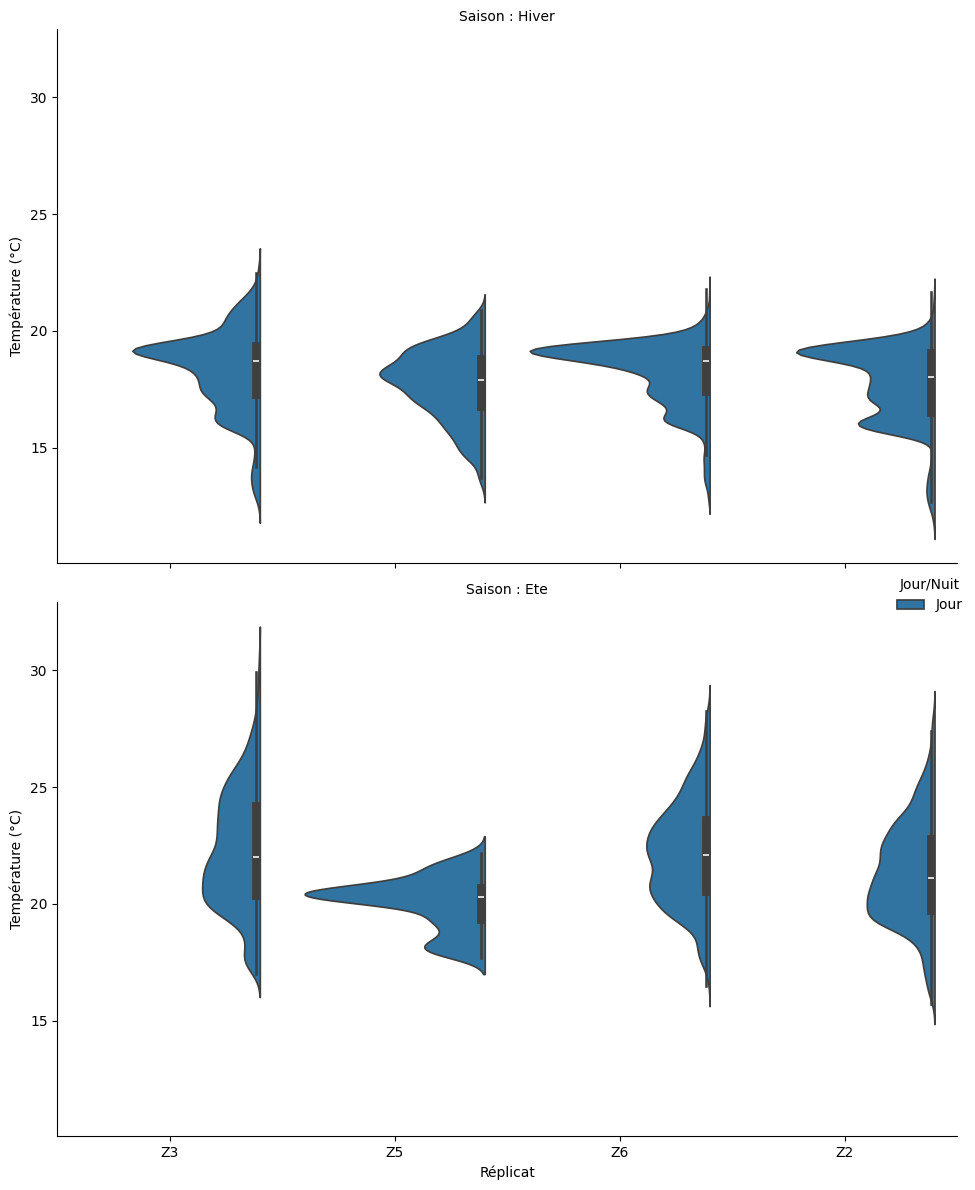

In [55]:
# Initialiser une grille de facettes avec "Été/Hiver"
g = sns.FacetGrid(data_celsius, col="Ete/Hiver", col_wrap=1, height=6, aspect=1.5)

# Ajouter un graphique en violon à chaque facette
g.map_dataframe(
    sns.violinplot,
    x="Réplicat",  # Axe catégoriel
    y="Valeur",    # Température
    hue="Jour/Nuit",  # Différencier les périodes Jour/Nuit
    split=True,    # Diviser les violons pour chaque catégorie
    palette="tab10"
)

# Ajouter des ajustements
g.set_titles("Saison : {col_name}")
g.set_axis_labels("Réplicat", "Température (°C)")
g.add_legend(title="Jour/Nuit")

# Ajuster l'affichage et montrer
plt.tight_layout()
plt.show()
